In [1]:
from src.main.graph_generation import main

import numpy as numpy
import nibabel as nib
import torch
import glob
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from skimage.segmentation import slic
import numpy as np
from collections import Counter
from torch.utils.data import random_split

In [2]:
import os
import torch
from torch_geometric.data import Dataset

from src.main.data import CustomGraphDataset

dataset = CustomGraphDataset(root="data/processed/c0_03__s1000/")
# for data in dataset:
#     print(data)

295

In [6]:
from torch_geometric.loader import DataLoader

dataloader = DataLoader(dataset, batch_size=4, shuffle=False)
next(iter(dataloader))

DataBatch(x=[2533, 4], edge_index=[2, 49213], edge_attr=[49213, 1], y=[2533], batch=[2533], ptr=[5])

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 256)
        self.conv2 = GCNConv(256, 16)
        self.conv3 = GCNConv(16, num_classes)

    def forward(self, graph):
        
        x, edge_index, edge_attr = graph.x.to(torch.float), graph.edge_index.to(torch.int64), graph.edge_attr.to(torch.float)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# model_test = GCN(num_features=4, num_classes=4).to('cuda')

In [8]:
train_ratio = 0.75
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [9]:
len(train_dataset), len(val_dataset)

(221, 74)

In [10]:
all_labels = []
for batch in dataloader:
    all_labels.extend(batch.y.numpy())

class_counts = Counter(all_labels)
total_count = float(sum(class_counts.values()))
class_weights = {cls: total_count / count for cls, count in class_counts.items()}
weights = torch.tensor([class_weights[i] for i in range(4)], dtype=torch.float32).to("cuda")


In [11]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split
from torch_geometric.loader import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, f1_score

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = GCN(num_features=4, num_classes=4).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

writer = SummaryWriter("runs/c0_03__s1000")
best_val_accuracy = 0.0

for epoch in range(1000):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to("cuda")
        out = model(batch)

        loss = F.nll_loss(out, batch.y.to(torch.long), weight=weights)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(out, 1)
        total_correct += (predicted == batch.y.to(torch.long)).sum().item()
        total_samples += batch.y.size(0)

    train_accuracy = total_correct / total_samples

    # Validation phase
    model.eval()
    val_total_correct = 0
    val_total_samples = 0
    val_total_loss = 0.0

    with torch.no_grad():
        for val_batch in val_loader:
            val_batch = val_batch.to("cuda")
            val_out = model(val_batch)

            val_loss = F.nll_loss(val_out, val_batch.y.to(torch.long), weight=weights)
            val_total_loss += val_loss.item()

            _, val_predicted = torch.max(val_out, 1)
            val_total_correct += (
                (val_predicted == val_batch.y.to(torch.long)).sum().item()
            )
            val_total_samples += val_batch.y.size(0)

    val_accuracy = val_total_correct / val_total_samples

    writer.add_scalar("Loss/train", total_loss / len(train_loader), epoch)
    writer.add_scalar("Accuracy/train", train_accuracy, epoch)
    writer.add_scalar("Loss/val", val_total_loss / len(val_loader), epoch)
    writer.add_scalar("Accuracy/val", val_accuracy, epoch)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")
        # print(f'Saved the best model with validation accuracy: {best_val_accuracy:.4f}')

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch} | Train Loss: {total_loss / len(train_loader):.3f} | Train Accuracy: {train_accuracy:.4f} | Val Loss: {val_total_loss / len(val_loader):.3f} | Val Accuracy: {val_accuracy:.4f}"
        )

writer.close()

Epoch 0 | Train Loss: 1.374 | Train Accuracy: 0.4527 | Val Loss: 1.365 | Val Accuracy: 0.5065
Epoch 10 | Train Loss: 1.219 | Train Accuracy: 0.7341 | Val Loss: 1.252 | Val Accuracy: 0.5416
Epoch 20 | Train Loss: 1.207 | Train Accuracy: 0.6644 | Val Loss: 1.239 | Val Accuracy: 0.8274
Epoch 30 | Train Loss: 1.200 | Train Accuracy: 0.7117 | Val Loss: 1.199 | Val Accuracy: 0.6747
Epoch 40 | Train Loss: 1.186 | Train Accuracy: 0.7337 | Val Loss: 1.202 | Val Accuracy: 0.7521
Epoch 50 | Train Loss: 1.184 | Train Accuracy: 0.6767 | Val Loss: 1.215 | Val Accuracy: 0.7861
Epoch 60 | Train Loss: 1.176 | Train Accuracy: 0.6913 | Val Loss: 1.200 | Val Accuracy: 0.7719
Epoch 70 | Train Loss: 1.177 | Train Accuracy: 0.6467 | Val Loss: 1.221 | Val Accuracy: 0.7875
Epoch 80 | Train Loss: 1.167 | Train Accuracy: 0.7070 | Val Loss: 1.209 | Val Accuracy: 0.7885
Epoch 90 | Train Loss: 1.159 | Train Accuracy: 0.7287 | Val Loss: 1.209 | Val Accuracy: 0.6938
Epoch 100 | Train Loss: 1.154 | Train Accuracy: 0.6

In [64]:
sample = next(iter(dataloader)).to("cuda")
sample

DataBatch(x=[3329, 4], edge_index=[2, 66839], edge_attr=[66839, 1], y=[3329], batch=[3329], ptr=[5])

In [65]:
model_test(sample).argmax(dim=1).detach().to("cpu")[0:800]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [66]:
sample.y[0: 800]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [78]:
import torch

def get_classwise_acc(true_labels, predicted_labels):
    # true_labels, predicted_labels = sample.y.detach().to("cpu"), model_test(sample).argmax(dim=1).detach().to("cpu")

    true_positives = {}
    total_samples = {}

    for true, pred in zip(true_labels, predicted_labels):
        if true.item() in total_samples:
            total_samples[true.item()] += 1
        else:
            total_samples[true.item()] = 1

        if true == pred:
            if true.item() in true_positives:
                true_positives[true.item()] += 1
            else:
                true_positives[true.item()] = 1

    # Calculate class-wise accuracy
    class_wise_accuracy = {}
    for cls in total_samples:
        if cls in true_positives:
            class_wise_accuracy[cls] = true_positives[cls] / total_samples[cls]
        else:
            class_wise_accuracy[cls] = 0.0  # No true positives for this class

    print("Class-wise Accuracy:", class_wise_accuracy)


In [75]:
validation_sample = torch.load("../../data/processed/validation/008.pt").to("cuda")

In [77]:
model_test(validation_sample).detach().cpu().argmax(dim=1)

tensor([0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
        2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
        2, 0, 0, 0, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2,
        2, 1, 1, 1, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 2,
        2, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 0, 0, 0,
        2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 2, 2, 1, 2, 2, 0, 0, 0, 3, 0,
        2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
        0, 1, 1, 2, 0, 0, 0, 0, 2, 0, 2, 1, 1, 0, 2, 0, 0, 1, 0, 0, 0, 1, 2, 0,
        0, 2, 2, 2, 2, 1, 1, 2, 0, 1, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0,
        0, 0, 3, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2,
        0, 0, 2, 2, 3, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 1, 0, 2, 1, 3,
        0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2,

In [14]:
350*0.8

280.0

In [32]:
# validation = torch.load("../../data/processed/008.pt")
# validation

Data(x=[819, 4], edge_index=[2, 16479], edge_attr=[16479, 1], y=[819])

In [79]:
get_classwise_acc(validation.y, model_test(validation.to("cuda")).argmax(dim=1))

# reminder {1:necrotic, 2: edema, 3:enhancing}

Class-wise Accuracy: {0.0: 0.6824408468244084, 2.0: 0.6666666666666666, 3.0: 0.0}


In [26]:
t = torch.load("../../data/processed/0_05__1000/007.pt").to("cuda")
t.y

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

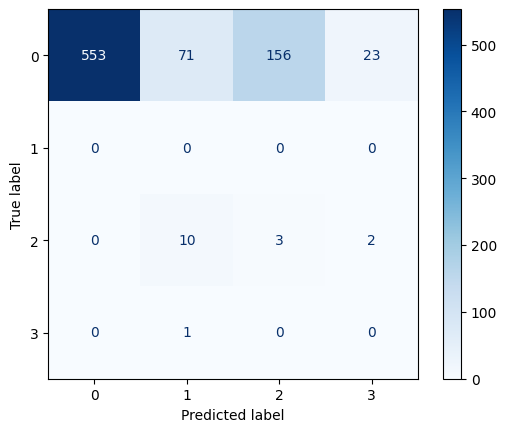

Class-wise Accuracy: [0.6886675       nan 0.2       0.       ]


/tmp/ipykernel_66121/2201379399.py:13: RuntimeWarning: invalid value encountered in divide
  class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)


In [83]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels, predicted_labels = validation.y.detach().cpu(), model_test(validation.to("cuda")).argmax(dim=1).detach().cpu()

cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)
print("Class-wise Accuracy:", class_wise_accuracy)


In [11]:
torch.load("../../data/processed/0_05__1000/003.pt")

Data(x=[855, 4], edge_index=[2, 16073], edge_attr=[16073, 1], y=[855])

In [27]:
import graph_generation as g

In [28]:
nii_loader = g.Nii_loader()

FileNotFoundError: No such file or no access: 'data/raw/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'

In [29]:
import pickle

def load_supervoxels(filename: str):
    with open(filename, 'rb') as f:
        list_of_supervoxels = pickle.load(f)
    return list_of_supervoxels



In [30]:
from graph_generation import SuperVoxel, Voxel

In [31]:
l = load_supervoxels("../../pickleGraphTest.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '../../pickleGraphTest.pkl'

In [9]:
!ls -la ../../

total 1276
drwxr-xr-x 10 tryfonm tryfonm   4096 May 25 04:51 .
drwxr-xr-x 41 tryfonm tryfonm   4096 Apr 27 17:30 ..
drwxr-xr-x  8 tryfonm tryfonm   4096 May 23 02:48 .git
-rw-r--r--  1 tryfonm tryfonm     93 Feb 12 00:07 .gitignore
-rw-r--r--  1 tryfonm tryfonm    725 Dec  1 22:12 Makefile
drwxr-xr-x  2 tryfonm tryfonm   4096 May  7 16:51 backup
drwxr-xr-x  4 tryfonm tryfonm   4096 May 23 22:40 data
drwxr-xr-x  2 tryfonm tryfonm   4096 Feb 23 13:35 models
drwxr-xr-x  4 tryfonm tryfonm   4096 May 23 21:49 notebooks
-rw-r--r--  1 tryfonm tryfonm    233 May 10 16:23 notes
-rw-r--r--  1 tryfonm tryfonm 817680 May 25 04:51 pickleGraphTest.py
-rw-r--r--  1 tryfonm tryfonm   1624 Nov 19  2023 requirements_backup.txt
drwxr-xr-x  3 tryfonm tryfonm   4096 Dec  1 22:12 runs
-rw-r--r--  1 tryfonm tryfonm    901 Apr  5 10:27 sista_error
-rw-r--r--  1 tryfonm tryfonm 423376 May 23 22:31 someRandomGraph.pt
drwxr-xr-x  4 tryfonm tryfonm   4096 Nov 19  2023 src
drwxr-xr-x  7 tryfonm tryfonm   4096 Nov 

In [ ]:
predictions = torch.zeros_like(torch.tensor(sample_image))
for sv_index, sv in enumerate(list_of_supervoxels):
    indices = tuple(zip(*sv.list_of_voxel_indices))
    predictions[indices] = predicted_labels[sv_index]